In [ ]:
import os
import re
import csv
import torch.nn.functional as F
import os
import torch
import numpy as np
import pandas as pd
import gzip
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_utils import make_numpy_array
directory = 'PATH_TO_FOLDERS'
scaler = StandardScaler()

folders = [folder for folder in os.listdir(
    directory) if os.path.isdir(os.path.join(directory, folder))]

#folders.sort()
final_tensors = []
da_bozo = []

def extract_values(folder_name):
    pattern = r'gamma_(\d+\.\d+)_reg_param_(\d+\.\d+)_adh_(\d+\.\d+)'
    match = re.match(pattern, folder_name)
    if match:
        gamma = float(match.group(1))
        reg_param = float(match.group(2))
        adh = float(match.group(3))
        return gamma, reg_param, adh
    else:
        return None


data_csv = []
for folder in folders:
    folder_path = os.path.join(directory, folder)
    
    print(f"Processing subfolder: {folder_path}")
   


    pickle_files = [file for file in os.listdir(
        folder_path) if file.endswith('.pickle')]

    tensor_list = []

    count_large = 0

    for pickle_file in pickle_files:

        pickle_to_dict = np.load(os.path.join(
            folder_path, pickle_file), allow_pickle=True)

        df = make_numpy_array(pickle_to_dict)

        i, j = df.shape[0], df.shape[1]

        df = scaler.fit_transform(df.view(-1, 1))
        df = torch.tensor(df).view(i, j)
        #print(df.shape)
        tensor_list.append(df)

    tensored_stuff = torch.cat(tensor_list, dim=0)
    da_bozo.append(tensored_stuff)



In [2]:
import xgboost as xgb
import csv
from data_utils import *
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
datas = torch.load('DATA_PATH')
parameter_values = []


# Below block reads parameter values from a CSV file
csv_file_path = "PARAMETER_VALUES_CSV_PATH"
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        parameter_values.append(list(map(float, row)))
# Convert the parameter values list to a tensor
parameter_values_tensor = torch.tensor(parameter_values, dtype=torch.float32)
final_param_labels = parameter_values_tensor.unsqueeze(
    1).repeat(1, 10, 1).reshape(-1, 3)


reshaped_data = datas.view(1000, 1657, 10).transpose(2, 1)

## Get original length simulations (remove padding) and store them to a list
unwrapped_pizza = []
for i in range(1000):
    ax = reshaped_data[i]
    ravioli = unravel(ax)
    unwrapped_pizza.append(ravioli)

net = load_model_from_checkpoint(
    'PATH_TO_CHECKPOINT')
device = 'cuda'
net = net.to(device)
# Pass entire dataset through the trained model and store the output embeddings
output_embeddings = []
for i in unwrapped_pizza:
    i = i.to(device)
    output_embeddings.append(net(i.unsqueeze(0)).detach().cpu().numpy())
output_embeddings = np.array(output_embeddings)
output_embeddings = np.squeeze(output_embeddings, axis=1)
output_embeddings.shape
final_param_labels_np = final_param_labels.numpy()


### Train XGBoost regression model
X = output_embeddings
y = final_param_labels_np[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

# Initialize and train XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


def calc_adj_r2(r2, n=1000, p=1):
    return 1 - ((1 - r2) * (n - 1)) / (n - p)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")
print(f"Adjusted R2 Score: {calc_adj_r2(r2, p=3):.4f}")

# Calculate and print label-wise R2 scores
label_r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
for i, score in enumerate(label_r2_scores):
    print(f"Label {i+1} R2 Score: {score:.4f}")
    print(f"Label {i+1} Adjusted R2 Score: {calc_adj_r2(score):.4f}")
    print()



Mean Squared Error: 7.890222549438477
R2 Score: 0.9877
Adjusted R2 Score: 0.9877
Label 1 R2 Score: 0.9874
Label 1 Adjusted R2 Score: 0.9874

Label 2 R2 Score: 0.9880
Label 2 Adjusted R2 Score: 0.9880



In [3]:

from data_utils import *
import numpy as np
parameter_values_exp = []
csv_file_path = "PARAMETER_VALUES_CSV_PATH_FOR_NEW_SIMULATIONS"
with open(csv_file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader)  # Skip the header row
    for row in csv_reader:
        parameter_values_exp.append(list(map(float, row)))

# Convert the parameter values list to a tensor
parameter_values_tensor_300 = torch.tensor(parameter_values_exp, dtype=torch.float32)



output_embeddings_exp = []


for m in da_bozo:
    m = m.transpose(1, 0).float().to(device)
    output_embeddings_exp.append(net(m.unsqueeze(0)).detach().cpu().numpy())

output_embeddings_exp = np.array(output_embeddings_exp)
output_embeddings_exp = np.squeeze(output_embeddings_exp, axis=1)


In [5]:
X1= output_embeddings
X2 = output_embeddings_exp
y1= final_param_labels_np[:,:-1]
y2 = parameter_values_tensor_300[:,:-1]

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Initialize and train XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


def calc_adj_r2(r2, n=1000, p=1):
    return 1 - ((1 - r2) * (n - 1)) / (n - p)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")


# Calculate and print label-wise R2 scores
label_r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
for i, score in enumerate(label_r2_scores):
    print(f"Label {i+1} R2 Score: {score:.4f}")
   


Mean Squared Error: 21.04143714904785
R2 Score: 0.9638
Label 1 R2 Score: 0.9622
Label 2 R2 Score: 0.9653


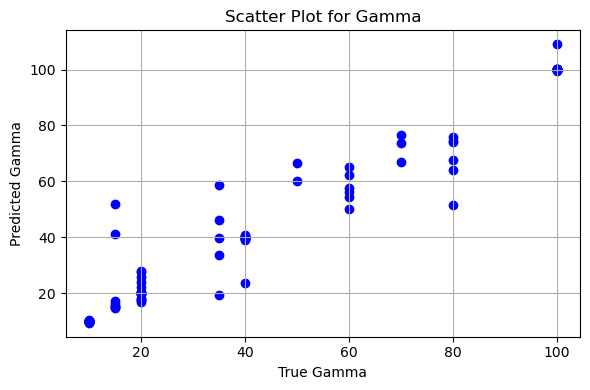

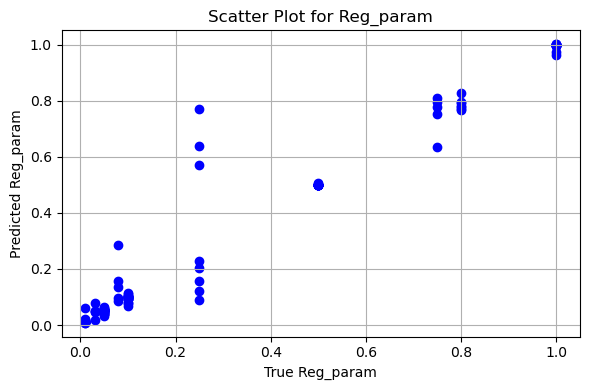

In [6]:
import matplotlib.pyplot as plt
true_parameters= y_test.T
predicted_parameters = y_pred.T
parameter_names = ['Gamma', 'Reg_param', 'Adhesion']

# Create scatter plots
for i in range(2):
    plt.figure(figsize=(6, 4))
    plt.scatter(true_parameters[i], predicted_parameters[i],
                color='blue', label='Data Points')
    plt.plot([true_parameters[i], true_parameters[i]], [predicted_parameters[i],
             predicted_parameters[i]], color='red', linewidth=1, linestyle='--', label='Ideal Line')
    plt.xlabel('True ' + parameter_names[i])
    plt.ylabel('Predicted ' + parameter_names[i])
    plt.title('Scatter Plot for ' + parameter_names[i])
    #plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


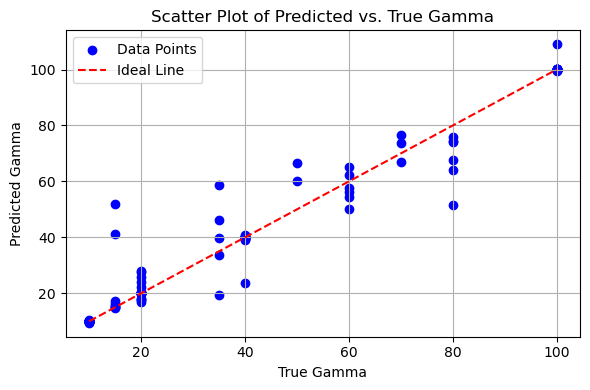

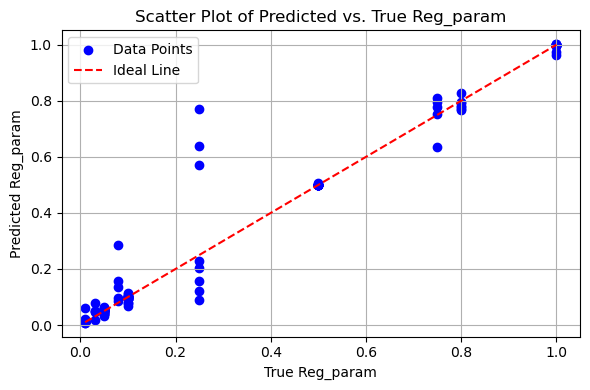

In [7]:
for i in range(2):
    plt.figure(figsize=(6, 4))

    plt.scatter(true_parameters[i], predicted_parameters[i],
                color='blue', label='Data Points')
    plt.plot([true_parameters[i].min(), true_parameters[i].max()], [true_parameters[i].min(
    ), true_parameters[i].max()], color='red', linestyle='--', label='Ideal Line')

    plt.xlabel('True ' + parameter_names[i])
    plt.ylabel('Predicted ' + parameter_names[i])
    plt.title('Scatter Plot of Predicted vs. True ' + parameter_names[i])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Parameter: Gamma
R-squared: 0.9622451025156383
MAE: 2.6132998
RMSE: 6.4867387
Pearson Correlation Coefficient: 0.9810184859945396
p-value: 4.6743305083983305e-93


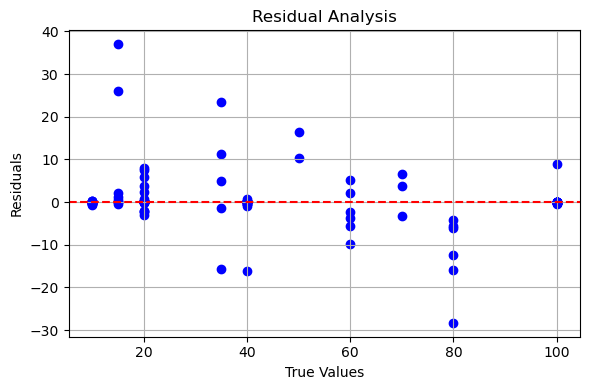

--------------------------------------------------
Parameter: Reg_param
R-squared: 0.9653261761711506
MAE: 0.022914948
RMSE: 0.071358755
Pearson Correlation Coefficient: 0.9829190855028868
p-value: 5.795396934774343e-96


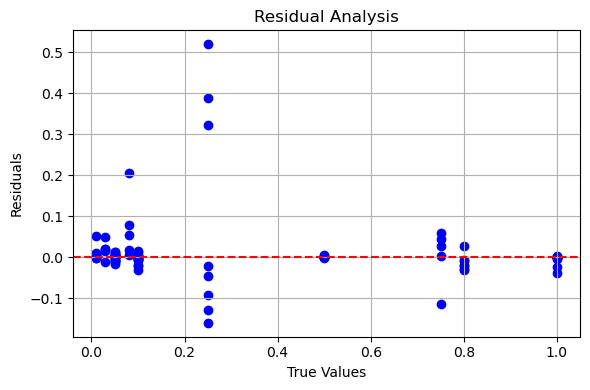

--------------------------------------------------


In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr



for i in range(2):
    print("Parameter:", parameter_names[i])
    r2 = r2_score(true_parameters[i], predicted_parameters[i])
    print("R-squared:", r2)
    mae = mean_absolute_error(true_parameters[i], predicted_parameters[i])
    rmse = np.sqrt(mean_squared_error(true_parameters[i], predicted_parameters[i]))

    print("MAE:", mae)
    print("RMSE:", rmse)
    correlation_coefficient, p_value = pearsonr(
        true_parameters[i], predicted_parameters[i])
    print("Pearson Correlation Coefficient:", correlation_coefficient)
    print("p-value:", p_value)
    
    residuals = predicted_parameters[i] - true_parameters[i]

    plt.figure(figsize=(6, 4))
    plt.scatter(true_parameters[i], residuals, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("--------------------------------------------------")
